In [158]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def sensitivity(m_p):
    return round((m_p[0][0]/(m_p[0][0] + m_p[0][1])), 4)
def specificity(m_p):
    return round((m_p[1][1]/(m_p[1][0] + m_p[1][1])), 4)

def plot_class(X_syn_test, y_syn_test, model, method):
        X_pred_0 = X_syn_test[y_syn_test == 0]
        X_pred_1 = X_syn_test[y_syn_test == 1]
        x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
        y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
        plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
        plt.title(f'Powierzchnia decyzyjna {method}')
        plt.xlabel('Cecha 1')
        plt.ylabel('Cecha 2')
        plt.legend()

def pred_info(y_test, y_pred, name_of_method):
    accuracy = accuracy_score(y_test, y_pred)
    c_matrix = confusion_matrix(y_test, y_pred)
    print(f'\n{name_of_method}:')
    print(f'Macierz pomylek: \n{c_matrix}')
    print(f'Dokladnosc: {accuracy}\nCzulosc: {sensitivity(c_matrix)}\nSwoistosc: {specificity(c_matrix)}')

In [159]:
class MSE:
    def loss(self, predicted, target):
        return np.sum((predicted - target) ** 2)

    def grad(self, predicted, target):
        return 2 * (predicted - target)

In [160]:
class Linear:
    def __init__(self, input_size: int, output_size: int) -> None:
        self.params = {}
        self.grads = {}        
        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs):
        self.inputs = inputs
        return inputs @ self.params["w"] + self.params["b"]

    def backward(self, grad):
        self.grads["b"] = np.sum(grad, axis=0)
        self.grads["w"] = self.inputs.T @ grad
        return grad @ self.params["w"].T

In [161]:
class Activation:

    def __init__(self, f, f_prime) -> None:
        self.params = {}
        self.grads = {}   
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs):
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad):
        return self.f_prime(self.inputs) * grad


def ReLu_actv(X):
        return np.maximum(0, X)
def ReLu_deriv(X):
    return np.where(X >= 0, 1, 0)

def logistic_actv(X):
        return 1 / (1 + np.exp(-X))
def logistic_deriv(X):
    y = logistic_actv(X)
    return y * (1-y)

class ReLu(Activation):
     def __init__(self):
          super().__init__(ReLu_actv, ReLu_deriv)

class Logistic(Activation):
     def __init__(self):
          super().__init__(logistic_actv, logistic_deriv)

In [162]:
class NeuralNet:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def params_and_grads(self):
        for layer in self.layers:
            for name, param in layer.params.items():
                grad = layer.grads[name]
                yield param, grad

    def predict(self, inputs):
        y_pred = []
        for layer in self.layers:
            inputs = layer.forward(inputs)
        self.proba = inputs
        for predict in inputs:
            y_pred.append(np.argmax(predict))
        return np.array(y_pred)
    
    def predict_proba(self):
        proba = []
        for predict in self.proba:
            proba.append(predict[np.argmax(predict)])
        return np.array(proba)

In [163]:
class SGD:
    def __init__(self, eta=0.01):
        self.eta = eta

    def step(self, net):
        for param, grad in net.params_and_grads():
            param -= self.eta * grad

In [164]:
from typing import NamedTuple
Batch = NamedTuple("Batch", [("inputs", np.array), ("targets", np.array)])

class BatchIterator:
    def __init__(self, batch_size = 32, shuffle = True) -> None:
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __call__(self, inputs, targets):
        starts = np.arange(0, len(inputs), self.batch_size)
        if self.shuffle:
            np.random.shuffle(starts)

        for start in starts:
            end = start + self.batch_size
            batch_inputs = inputs[start:end]
            batch_targets = targets[start:end]
            yield Batch(batch_inputs, batch_targets)

In [165]:
def train(net, inputs, targets, num_epochs = 5000, iterator = BatchIterator(), 
          loss = MSE(), optimizer = SGD()) -> None:
    for _ in range(num_epochs):
        epoch_loss = 0.0
        for batch in iterator(inputs, targets):
            predicted = net.forward(batch.inputs)
            epoch_loss += loss.loss(predicted, batch.targets)
            grad = loss.grad(predicted, batch.targets)
            net.backward(grad)
            optimizer.step(net)

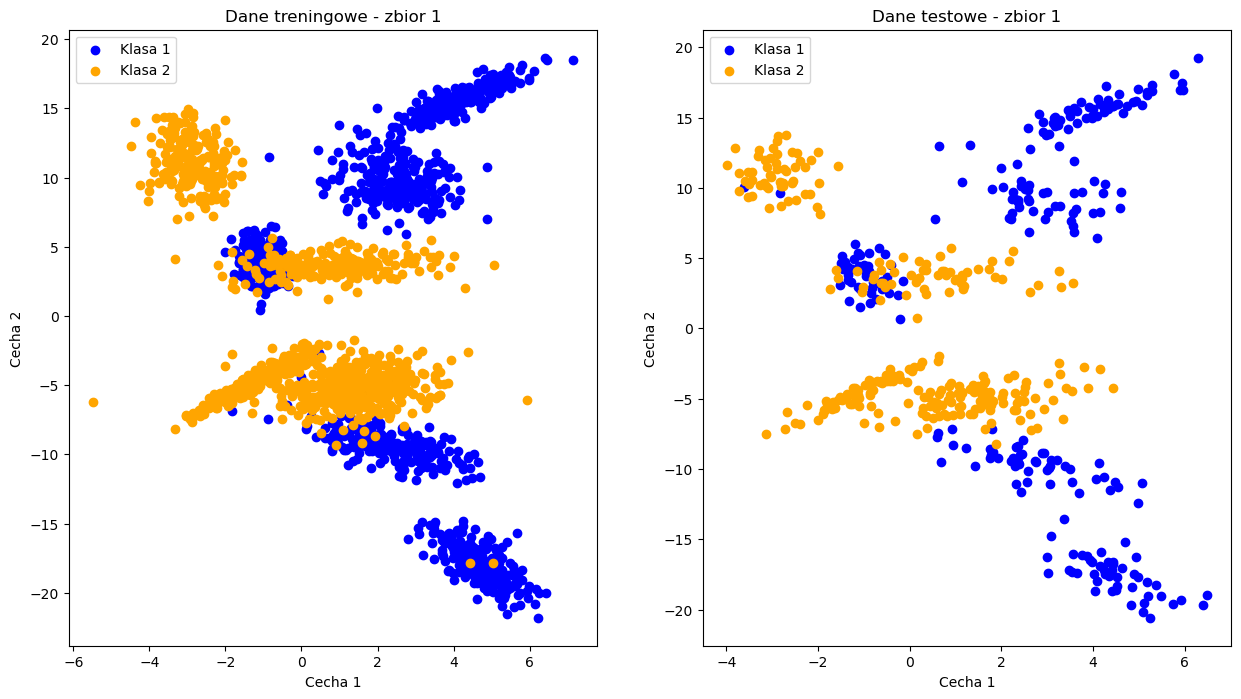

In [166]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Dane wejsciowe
X, t = make_classification(n_samples=2597, n_features=4, n_informative=4, n_repeated=0, n_clusters_per_class=5, random_state=254397, hypercube=False, n_redundant=0, class_sep=20)
X = X[:,:2]
#Podzial na podzbiory
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X, t, test_size=0.2, random_state=254397)

# Podzial zbiorow na klasy w celu ich wyswietlenia
klasa_0_train = X_train_4[(y_train_4 == 0)]
klasa_1_train = X_train_4[(y_train_4 == 1)]
klasa_0_test = X_test_4[(y_test_4 == 0)]
klasa_1_test = X_test_4[(y_test_4 == 1)]

# Wyswietlenie danych
_, axs = plt.subplots(1, 2, figsize=(15, 8))
ax = axs[0]
ax.scatter(klasa_0_train[:,0], klasa_0_train[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_train[:,0], klasa_1_train[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane treningowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()

ax = axs[1]
ax.scatter(klasa_0_test[:,0], klasa_0_test[:,1], c = "blue", label="Klasa 1")
ax.scatter(klasa_1_test[:,0], klasa_1_test[:,1], c = "orange", label="Klasa 2")
ax.set_title("Dane testowe - zbior 1")
ax.set_xlabel("Cecha 1")
ax.set_ylabel("Cecha 2")
ax.legend()
y_train_4e = np.array([[0, 1] if t == 1 else [1, 0] for t in y_train_4])
y_test_4e = np.array([[0, 1] if t == 1 else [1, 0] for t in y_test_4])

In [167]:
net_relu = NeuralNet([
    Linear(input_size=2, output_size=4),
    ReLu(),
    ReLu(),
    ReLu(),
    Linear(input_size=4, output_size=2)
])
train(net_relu, X_train_4, y_train_4e)
y_pred_relu = net_relu.predict(X_test_4)

net_log = NeuralNet([
    Linear(input_size=2, output_size=4),
    Logistic(),
    Logistic(),
    Logistic(),
    Linear(input_size=4, output_size=2)
])
train(net_log, X_train_4, y_train_4e)
y_pred_log = net_log.predict(X_test_4)

net_mix = NeuralNet([
    Linear(input_size=2, output_size=4),
    Logistic(),
    ReLu(),
    Logistic(),
    Linear(input_size=4, output_size=2)
])
train(net_mix, X_train_4, y_train_4e)
y_pred_mix = net_mix.predict(X_test_4)

C:\Users\Dominik\AppData\Local\Temp\ipykernel_2248\4263416152.py:10: RuntimeWarning: overflow encountered in matmul
  return inputs @ self.params["w"] + self.params["b"]
C:\Users\Dominik\AppData\Local\Temp\ipykernel_2248\4263416152.py:14: RuntimeWarning: invalid value encountered in matmul
  self.grads["w"] = self.inputs.T @ grad
C:\Users\Dominik\AppData\Local\Temp\ipykernel_2248\904761802.py:14: RuntimeWarning: invalid value encountered in multiply
  return self.f_prime(self.inputs) * grad
C:\Users\Dominik\AppData\Local\Temp\ipykernel_2248\4263416152.py:15: RuntimeWarning: invalid value encountered in matmul
  return grad @ self.params["w"].T



ReLu:
Macierz pomylek: 
[[247   0]
 [273   0]]
Dokladnosc: 0.475
Czulosc: 1.0
Swoistosc: 0.0

Logistyczna:
Macierz pomylek: 
[[223  24]
 [ 24 249]]
Dokladnosc: 0.9076923076923077
Czulosc: 0.9028
Swoistosc: 0.9121

Mix:
Macierz pomylek: 
[[239   8]
 [ 24 249]]
Dokladnosc: 0.9384615384615385
Czulosc: 0.9676
Swoistosc: 0.9121


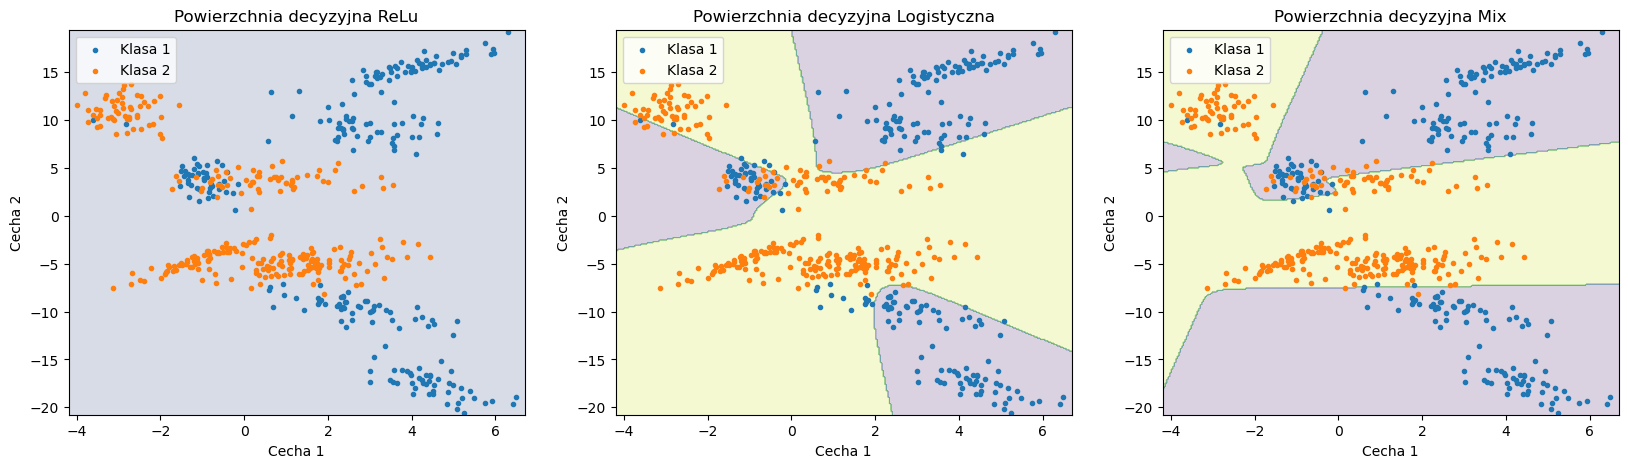

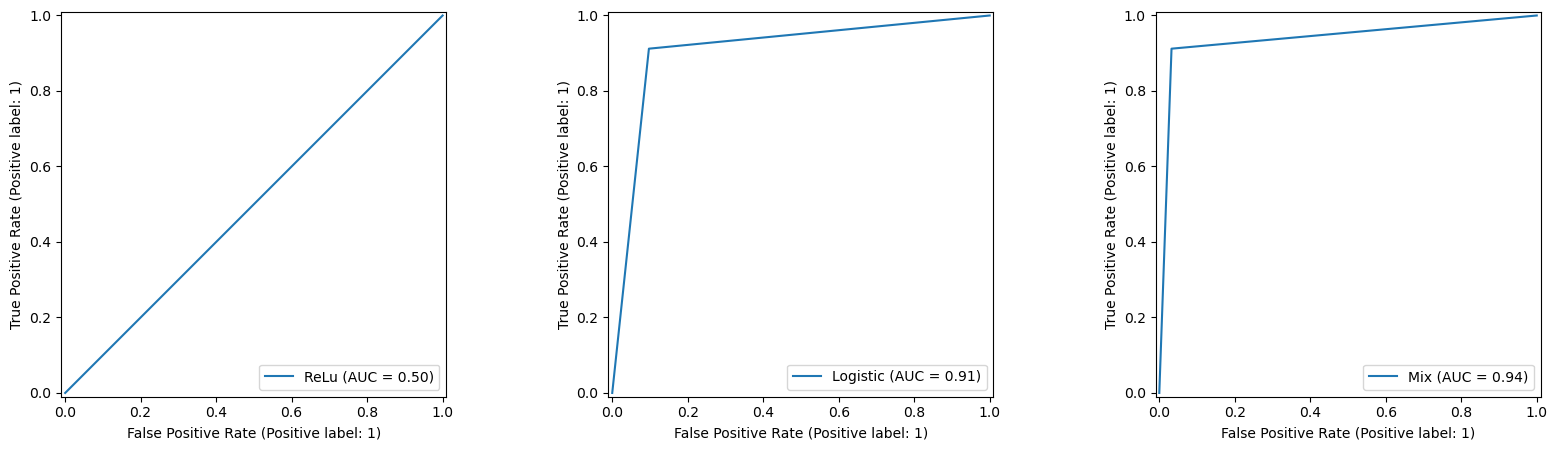

In [168]:
from sklearn.metrics import RocCurveDisplay

pred_info(y_test_4, y_pred_relu, 'ReLu')
pred_info(y_test_4, y_pred_log, 'Logistyczna')
pred_info(y_test_4, y_pred_mix, 'Mix')

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plot_class(X_test_4, y_test_4, net_relu, 'ReLu')
plt.subplot(1, 3, 2)
plot_class(X_test_4, y_test_4, net_log, 'Logistyczna')
plt.subplot(1, 3, 3)
plot_class(X_test_4, y_test_4, net_mix, 'Mix')

_, axs = plt.subplots(1, 3, figsize=(20, 5))
RocCurveDisplay.from_predictions(y_test_4, y_pred_relu, name='ReLu', ax=axs[0])
RocCurveDisplay.from_predictions(y_test_4, y_pred_log, name='Logistic', ax=axs[1])
RocCurveDisplay.from_predictions(y_test_4, y_pred_mix, name='Mix', ax=axs[2])

In [223]:
def binary_encode_single(y):
    encoding = [0] * 10
    encoding[y] = 1
    return encoding

def binary_encode_list(y):
    return np.array([binary_encode_single(x) for x in y])

In [177]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

In [217]:
X_train = trainset.data.numpy()
y_train = trainset.targets.numpy()

X_test = testset.data.numpy()
y_test = testset.targets.numpy()

n_samples, nx, ny = X_train.shape
X_train_flat = X_train.reshape((n_samples, nx * ny))
y_train_e = binary_encode_list(y_train)

n_samples, nx, ny = X_test.shape
X_test_flat = X_test.reshape((n_samples, nx * ny))
y_test_e = binary_encode_list(y_test)

In [232]:
net_mnist = NeuralNet([
    Linear(input_size=784, output_size=100),
    Logistic(),
    Linear(input_size=100, output_size=10)
])
train(net_mnist, X_train_flat, y_train_e, num_epochs=5000, optimizer=SGD(eta=0.001))
y_pred_mnist = net_mnist.predict(X_test_flat)

C:\Users\Dominik\AppData\Local\Temp\ipykernel_2248\904761802.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


In [233]:
from sklearn.metrics import classification_report
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(y_test, y_pred_mnist, target_names=classes))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.95      0.88      0.91      1032
           3       0.84      0.91      0.87      1010
           4       0.96      0.85      0.90       982
           5       0.90      0.86      0.88       892
           6       0.95      0.91      0.93       958
           7       0.95      0.92      0.93      1028
           8       0.79      0.93      0.85       974
           9       0.87      0.91      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

